## Data Loading

In [18]:
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split


def load_data(path: Path) -> pd.DataFrame:
    data = pd.read_csv(path)
    data = pd.DataFrame(
        {
            "job_description": data[
                ["company_profile", "description", "requirements", "benefits"]
            ]
            .fillna("")
            .agg(" ".join, axis=1),
            "fraudulent": data["fraudulent"],
        }
    )
    data = data.drop_duplicates(subset=["job_description"], keep="first")
    return data


def split_data(data: pd.DataFrame):
    X_train, X_test, y_train, y_test = train_test_split(
        data["job_description"],
        data["fraudulent"],
        test_size=0.2,
        random_state=42,
        stratify=data["fraudulent"],
    )

    # Convert to DataFrame for easy manipulation
    train_df = pd.DataFrame({'job_description': X_train, 'fraudulent': y_train})

    # Separate fraudulent (y=1) and non-fraudulent (y=0) samples
    fraudulent_df = train_df[train_df['fraudulent'] == 1]
    non_fraudulent_df = train_df[train_df['fraudulent'] == 0]
    print(fraudulent_df.shape, non_fraudulent_df.shape)

    # Oversample each fraudulent job description exactly 21 times
    fraudulent_df_oversampled = pd.concat([fraudulent_df] * 21, ignore_index=True)

    # Combine the oversampled fraudulent data with the original non-fraudulent data
    train_df_oversampled = pd.concat([non_fraudulent_df, fraudulent_df_oversampled], ignore_index=True)

    # Shuffle the data
    train_df_oversampled = train_df_oversampled.sample(frac=1, random_state=42).reset_index(drop=True)

    # Extract the oversampled X_train and y_train
    X_train: pd.Series[str] = train_df_oversampled['job_description']
    y_train: pd.Series[int] = train_df_oversampled['fraudulent']

    return X_train, X_test, y_train, y_test


In [19]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shivamb/real-or-fake-fake-jobposting-prediction")

print("Path to dataset files:", path)
from pathlib import Path
data = load_data(path + "/fake_job_postings.csv")
X_train, X_test, y_train, y_test = split_data(data)
print(X_train.head())
print(y_train.head())


In [ ]:
import torch
from torch.utils.data import Dataset
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import os
os.environ["WANDB_DISABLED"] = "true"

# Custom Dataset to handle our job descriptions and labels
class JobDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        """
        Args:
            texts (pd.Series or list): The job descriptions.
            labels (pd.Series or list): The corresponding labels (0 or 1).
            tokenizer (PreTrainedTokenizer): Tokenizer for BERT.
            max_length (int): Maximum token length for each text.
        """
        # Convert pandas Series to list if needed
        self.texts = texts.tolist() if hasattr(texts, 'tolist') else texts
        self.labels = labels.tolist() if hasattr(labels, 'tolist') else labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        # Tokenize the text with truncation and padding
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        # Squeeze to remove the batch dimension
        encoding = {key: tensor.squeeze(0) for key, tensor in encoding.items()}
        encoding['labels'] = torch.tensor(label, dtype=torch.long)
        return encoding

# Load the pre-trained BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Assuming X_train, X_test, y_train, y_test have been defined as in your preprocessing step
# Create our dataset objects
train_dataset = JobDataset(X_train, y_train, tokenizer, max_length=512)
test_dataset = JobDataset(X_test, y_test, tokenizer, max_length=512)

# Load pre-trained BERT model for sequence classification (binary classification => num_labels=2)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Define a metric function for evaluation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# Set up training arguments
training_args = TrainingArguments(
    output_dir='./results',             # output directory
    num_train_epochs=1,                 # total number of training epochs
    per_device_train_batch_size=16,     # batch size per device during training
    per_device_eval_batch_size=16,      # batch size for evaluation
    evaluation_strategy='epoch',        # evaluate at the end of each epoch
    save_strategy='epoch',              # save checkpoint at the end of each epoch
    logging_dir='./logs',               # directory for storing logs
    logging_steps=10,
    load_best_model_at_end=True,        # load the best model when finished training
    metric_for_best_model="accuracy",   # use accuracy to evaluate the best model
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Fine-tune the model
trainer.train()

# Optionally, evaluate the model on the test set after training
eval_results = trainer.evaluate()
print("Evaluation results:", eval_results)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.043600,0.101937,0.985137,0.876033,0.773723,0.821705


Evaluation results: {'eval_loss': 0.1019371896982193, 'eval_accuracy': 0.9851373182552504, 'eval_precision': 0.8760330578512396, 'eval_recall': 0.7737226277372263, 'eval_f1': 0.8217054263565892, 'eval_runtime': 48.677, 'eval_samples_per_second': 63.582, 'eval_steps_per_second': 3.985, 'epoch': 1.0}


In [ ]:
from huggingface_hub import login
from transformers import AutoModelForSequenceClassification, AutoTokenizer
# from google.colab import userdata

# login(token=userdata.get('HF_TOKEN'))
trainer.save_model("./fine_tuned_bert")
tokenizer.save_pretrained("./fine_tuned_bert")

repo = "pcloud/job_catcher-bert-base-uncased"

# Replace 'your-huggingface-username' with your actual username
repo_name = "your-huggingface-username/fine-tuned-bert-fake-jobs"

# Load saved model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("./fine_tuned_bert")
tokenizer = AutoTokenizer.from_pretrained("./fine_tuned_bert")

# Push to Hugging Face Hub
model.push_to_hub(repo)
tokenizer.push_to_hub(repo)



model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/pcloud/job_catcher-bert-base-uncased/commit/6c2dcffd6e313c478471644c6022efa59111f476', commit_message='Upload tokenizer', commit_description='', oid='6c2dcffd6e313c478471644c6022efa59111f476', pr_url=None, repo_url=RepoUrl('https://huggingface.co/pcloud/job_catcher-bert-base-uncased', endpoint='https://huggingface.co', repo_type='model', repo_id='pcloud/job_catcher-bert-base-uncased'), pr_revision=None, pr_num=None)

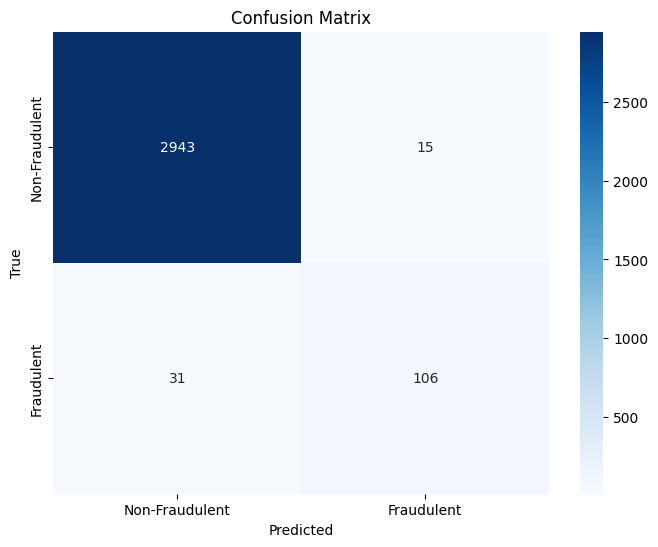

'              precision    recall  f1-score   support\n\n           0       0.99      0.99      0.99      2958\n           1       0.88      0.77      0.82       137\n\n    accuracy                           0.99      3095\n   macro avg       0.93      0.88      0.91      3095\nweighted avg       0.98      0.99      0.98      3095\n'

In [25]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions on the test set
predictions = trainer.predict(test_dataset)

# Get predicted labels
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Evaluate with per-class precision, recall, F1-score
print(classification_report(y_test, predicted_labels))

# Compute and plot the confusion matrix
cm = confusion_matrix(y_test, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Non-Fraudulent", "Fraudulent"],
            yticklabels=["Non-Fraudulent", "Fraudulent"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
#               precision    recall  f1-score   support

#            0       0.99      0.99      0.99      2958
#            1       0.88      0.77      0.82       137

#     accuracy                           0.99      3095
#    macro avg       0.93      0.88      0.91      3095
# weighted avg       0.98      0.99      0.98      3095

In [20]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

# Replace with your uploaded model name
model_name = repo

# Load model and tokenizer from Hugging Face Hub
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Set model to evaluation mode
model.eval()

def predict(job_text, model, tokenizer):
    inputs = tokenizer(
        job_text,
        truncation=True,
        padding="max_length",
        max_length=512,
        return_tensors="pt"
    )

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    prediction = torch.argmax(logits, dim=-1).item()  # 0 = Real, 1 = Fake
    return "Fake Job Posting" if prediction == 1 else "Real Job Posting"

# Example usage:
new_job_posting = "Alliance is looking for people who are passionate about both the work they do and the life they live.We are a high energy, goal oriented organization who is seeking out like minded professionals to assist our organization in continued growth. Alliance is an industry leader in providing innovative point-of-sale (POS) payment acceptance capabilities -- and backing them up with service, financial strength and stability.We offer flexibility, uncapped success, autonomy and life/work balance.You would be hard pressed to find a company that will treat you better. We offer daily/monthly contests and yearly bonuses for top employees. Come see why AMS is one of the fastest growing companies."
result = predict(new_job_posting, model, tokenizer)
result


'Fake Job Posting'

(3095,)